In [1]:
import requests
import json
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pynvml import *
import psutil
import os

C:\Users\HP\AppData\Local\Temp\ipykernel_3992\2238081627.py:16: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  from pynvml import *


In [2]:
try:
    df = pd.read_csv("../../../test_llm.csv")
except FileNotFoundError:
    print("Error: File 'test_llm.csv' not found.")
    print("Pastikan file tersebut berada di direktori yang sama dengan script ini.")
    exit()

In [3]:
test_df = df.copy()
test_df['label_score'] = test_df['Emotion']

In [4]:
url = "http://localhost:11434/api/chat"
model_name = "gemma3:12b"

In [5]:
# =================================================================
# === GPU / RAM Monitor ===
# =================================================================
try:
    from pynvml import *
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    def get_vram_usage_gb():
        info = nvmlDeviceGetMemoryInfo(handle)
        return info.used / (1024 ** 3)
except Exception:
    def get_vram_usage_gb():
        return 0.0 

def get_ram_usage_gb():
    return psutil.virtual_memory().used / (1024 ** 3)

# =================================================================
# === INISIALISASI VARIABEL ===
# =================================================================
emotion_labels = ["Anger", "Fear", "Happy", "Love", "Sadness"]
predictions = []
start_time = time.time()
REQUEST_TIMEOUT = 120 # Timeout dalam detik untuk request API

# =================================================================
# === LOOP INFERENSI ===
# =================================================================

print(f"🚀 Memulai inferensi menggunakan model: {model_name}...")
print("-" * 50)

for i, row in test_df.iterrows():
    teks = row["Customer Review"]

    # === SYSTEM PROMPT ===
    system_prompt = """
    Anda adalah asisten AI yang ahli dalam analisis emosi pada teks Bahasa Indonesia. 
    Tugas Anda adalah mengklasifikasikan teks pengguna ke dalam salah satu dari 
    5 kelas emosi berikut: Anger, Fear, Happy, Love, dan Sadness.

    Gunakan panduan karakteristik berikut:

    1. ANGER
    - Mengandung kata kasar atau makian.
    - Menunjukkan kemarahan, kekesalan, atau kebencian.
    - Keluhan atau ketidaksukaan terhadap produk/layanan/pengiriman.
    - Menggunakan huruf kapital berlebihan atau tanda baca marah (“!!!”, “???”).
    - Ekspresi jengkel, sebel, atau benci.

    2. FEAR
    - Kalimat peringatan atau rasa takut.
    - Kekhawatiran terhadap produk atau penjual.
    - Keraguan, ketidakpastian, atau menanyakan hal yang membuat cemas.
    - Ekspresi hati-hati, waspada, curiga, atau ragu terhadap keamanan.

    3. HAPPY
    - Mengandung pujian.
    - Kepuasan terhadap produk/penjual.
    - Ekspresi senang, gembira, bahagia, atau puas.
    - Bangga dan memberikan penilaian positif terhadap kualitas produk/penjual.

    4. LOVE
    - Ekspresi perasaan sayang, suka, atau rasa cinta.
    - Sangat puas terhadap produk.
    - Mengandung ungkapan hiperbola/“berlebihan” untuk menyanjung.
    - Mengandung pujian kuat atau kekaguman mendalam.
    - Ekspresi bangga atau sangat menyukai produk/penjual.

    5. SADNESS
    - Menyatakan kekecewaan terhadap produk.
    - Penyesalan, sedih, atau tidak puas.
    - Ekspresi kecewa, menyesal, atau merasa dirugikan.

    Keluaran Anda HARUS berupa JSON dengan format:
    {"emosi": "<Anger/Fear/Happy/Love/Sadness>"}
    """

    few_shot_examples = """
    Berikut adalah 25 contoh kasus klasifikasi emosi (25-SHOTS) beserta output JSON yang diharapkan. Model HARUS mengikuti format ini:

    --- Contoh 1 (Fear) ---
    Teks ulasan: "Barang tidak sesuai dengan yg di iklankan seperti nya bekas"
    Output: {"emosi": "Fear"}

    --- Contoh 2 (Fear) ---
    Teks ulasan: "Respon seller bagus tapi produknya tidak, suaranya kecil masih kalah dengan mic hp internal. Harga sangat tidak sesuai dengan kualitas"
    Output: {"emosi": "Fear"}

    --- Contoh 3 (Fear) ---
    Teks ulasan: "memang sih murah barang tapi boleh lah ya komplain btw ini saya yang enggak bisa pakai nya apa barang yang rusak ya sudah pakai splitter juga enggak fungsi"
    Output: {"emosi": "Fear"}

    --- Contoh 4 (Fear) ---
    Teks ulasan: "Barangnya yg dikirim tidak sesuai dg pesanan,saya pesan tas stitch dan pink minnie tp yg dikirim tas minion kedua duanya????"
    Output: {"emosi": "Fear"}

    --- Contoh 5 (Fear) ---
    Teks ulasan: "barang tidak sesuai gambar, kualitas seperti harganya, murahan. kapok belanja disini lagi."
    Output: {"emosi": "Fear"}
    
    --- Contoh 6 (Happy) ---
    Teks ulasan: "pengiriman cepat, packing rapi, kualitas mantap"
    Output: {"emosi": "Happy"}

    --- Contoh 7 (Happy) ---
    Teks ulasan: "Bagus, berkualitas, sesuai gbr. Makasih Seller, Tokped dan Kurir"
    Output: {"emosi": "Happy"}

    --- Contoh 8 (Happy) ---
    Teks ulasan: "mantap kipasnya kenceng, barangnya berkualitas sesuai sama harga"
    Output: {"emosi": "Happy"}

    --- Contoh 9 (Happy) ---
    Teks ulasan: "mantap kipasnya kenceng, barangnya berkualitas sesuai sama harga"
    Output: {"emosi": "Happy"}

    --- Contoh 10 (Happy) ---
    Teks ulasan: "barang sampai dengan selamat, dompet nya keren, bingkisan premium, seperti dompet mahal"
    Output: {"emosi": "Happy"}

    --- Contoh 11 (Anger) ---
    Teks ulasan: "Barang Rusak , Ga Guna Sama Sekali ... Parah"
    Output: {"emosi": "Anger"}

    --- Contoh 12 (Anger) ---
    Teks ulasan: "barang bosok! sekali Pake rusak.. mau claim dijawab berbelit ama adminnya"
    Output: {"emosi": "Anger"}

    --- Contoh 13 (Anger) ---
    Teks ulasan: "tidak sesuai gambar.... Janggan percaya ama Seller ini penipu..... kualitas jelek....."
    Output: {"emosi": "Anger"}

    --- Contoh 14 (Anger) ---
    Teks ulasan: "BARANG KW JANGAN BELI DISINI"
    Output: {"emosi": "Anger"}

    --- Contoh 15 (Anger) ---
    Teks ulasan: "ANJING TERNYATA PALSU INI BARANG BANGSAT2 AWAS KETIPU OI, YANG ASLI ADA SEGEL DISTRIBUTOR NYA"
    Output: {"emosi": "Anger"}

    --- Contoh 16 (Love) ---
    Teks ulasan: "Bagus banget keyboardnya. Packing sangat aman karena double kardus. Warna juga keren."
    Output: {"emosi": "Love"}

    --- Contoh 17 (Love) ---
    Teks ulasan: "Lucuu bangett.. Pengirimannya cepat, sellernya responsif banget.. Subuh2 di chat jg dijawab soalnya aku liat ini uda dr malam banget sih.. Kirain bakal baru dijawab agak siang.. Trnyata subuh uda dijawab?? informatif banget.. Ngsh tau klo dikasih oil agak berkabut.. Kirain bakal lbh berkabut dr ini.. Trnyata kabutnya cm kyk difoto.. Seneng deh.. Lampunya jg terang klo di tmpt gelap ?? makasihh yaa"
    Output: {"emosi": "Love"}

    --- Contoh 18 (Love) ---
    Teks ulasan: "waw murah bangetttt, packingnya rapih, produknya bagus keren mantap. sangat uhuuy pisan deh pokoknya hehehehehe"
    Output: {"emosi": "Love"}

    --- Contoh 19 (Love) ---
    Teks ulasan: "1. Pengiriman cepat 2. Seller Responsive 3. Barang nya bagus 4. Grip nya solid 5. meskipun bahan plastik tapi nyaman di genggam 6. Adjust nya juga berfungsi dengan baik 7. harganya murah bgt 8. puas beli ini"
    Output: {"emosi": "Love"}

    --- Contoh 20 (Love) ---
    Teks ulasan: "Terima Kasihh Boss, Mantappss.. Smoga Lancarr n Berkah Rezekinya..Smngttt Boss"
    Output: {"emosi": "Love"}

    --- Contoh 21 (Sadness) ---
    Teks ulasan: "Kecewa parah nggk berkah jualan gitu"
    Output: {"emosi": "Sadness"}

    --- Contoh 22 (Sadness) ---
    Teks ulasan: "Yg bikin kecewa pesen 6 items yg nyampe cuma satu. Masih saya tunggu kekurangan barangnya UNO STACKO KAYU, uno card 2pcs dan werewolf 2pcs. Kalau tidak tolong refund aja uangnya."
    Output: {"emosi": "Sadness"}

    --- Contoh 23 (Sadness) ---
    Teks ulasan: "Maaf pembelian yg ke 2 kali nya kecewa.. saya pesan 5 x 5 dus (isi 5), malah d kirim 2 dus (isi 12) jd kurang 1"
    Output: {"emosi": "Sadness"}

    --- Contoh 24 (Sadness) ---
    Teks ulasan: "ternyata sablonnya tidak sesuai dengan gambar huhu"
    Output: {"emosi": "Sadness"}

    --- Contoh 25 (Sadness) ---
    Teks ulasan: "barang yg dikirim tidak sesuai dengan barang yg dipesan."
    Output: {"emosi": "Sadness"}

    Klasifikasikan teks ulasan baru di bawah berdasarkan konteks 25 contoh di atas.
    """

    # === USER PROMPT (Ditingkatkan dengan instruksi yang lebih tegas) ===
    user_prompt = f"""
    {few_shot_examples}

    Teks ulasan yang harus diklasifikasikan: 
    "{teks}"

    Klasifikasikan teks tersebut ke dalam salah satu emosi berikut:
    {', '.join(emotion_labels)}.
    """

    # === Payload untuk API ===
    payload = {
        "model": model_name,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "format": "json",
        "stream": False
    }

    t0 = time.time()

    try:
        # === REQUEST DENGAN TIMEOUT ===
        response = requests.post(url, json=payload, timeout=REQUEST_TIMEOUT)
        response.raise_for_status()
        data = response.json()

        assistant_response_string = (
            data.get("response") or
            data.get("message", {}).get("content") or
            ""
        )
        
        if not assistant_response_string:
            print(f"[{i}] ⚠️ Respons kosong dari model untuk: {teks[:60]}...")
            # --- DEBUGGING: Cetak respons JSON lengkap di sini ---
            print(f"      Respons JSON lengkap dari API: {data}")
            # ----------------------------------------------------
            continue
            
        try:
            hasil = json.loads(assistant_response_string)
        except json.JSONDecodeError:
            print(f"[{i}] ⚠️ Gagal parse JSON dari respons teks mentah: {assistant_response_string}")
            continue

        emosi_pred = hasil.get("emosi", "").capitalize().strip()

        if emosi_pred not in emotion_labels:
            print(f"[{i}] 🛑 Emosi tidak valid ({emosi_pred}). Fallback ke Neutral.")
            emosi_pred = "Neutral"  # fallback jika model jawab aneh/tidak sesuai label

        latency = time.time() - t0
        ram_usage = get_ram_usage_gb()
        vram_usage = get_vram_usage_gb()

        predictions.append({
            "text": teks,
            "actual": row["Emotion"],
            "predicted": emosi_pred,
            "latency_sec": latency,
            "ram_gb": ram_usage,
            "vram_gb": vram_usage
        })

        print(f"[{i}] {teks[:60]}... → Pred: **{emosi_pred}** "
              f"({latency:.2f}s) | RAM: {ram_usage:.2f} GB | VRAM: {vram_usage:.2f} GB")

    except requests.exceptions.ConnectionError:
        print(f"\n❌ Tidak dapat terhubung ke Ollama di {url}. Pastikan Ollama sedang berjalan.")
        break
    except requests.exceptions.Timeout:
        print(f"[{i}] ⏰ Timeout ({REQUEST_TIMEOUT}s) saat memproses teks: {teks[:60]}...")
    except requests.exceptions.RequestException as e:
        print(f"[{i}] ❌ Kesalahan Request ({response.status_code}): {e}")
    except json.JSONDecodeError:
        print(f"[{i}] ⚠️ Gagal parse JSON dari respons: {assistant_response_string[:100]}...")
    except Exception as e:
        print(f"[{i}] ⚠️ Error tak terduga memproses teks: {teks[:60]} | Detail: {e}")

# =================================================================
# === RINGKASAN STATISTIK ===
# =================================================================
end_time = time.time()
total_time = end_time - start_time

if predictions:
    latencies = [p["latency_sec"] for p in predictions]
    # Abaikan latency pertama (warm-up)
    latencies_no_first = latencies[1:] if len(latencies) > 1 else latencies
    
    avg_latency = sum(latencies_no_first) / len(latencies_no_first) if latencies_no_first else 0
    total_time_no_first = sum(latencies_no_first)
    throughput = (len(latencies_no_first) / total_time_no_first) * 60 if total_time_no_first > 0 else 0

    avg_ram = sum(p["ram_gb"] for p in predictions) / len(predictions)
    avg_vram = sum(p["vram_gb"] for p in predictions) / len(predictions)

    print("\n" + "=" * 50)
    print("=== 📊 Ringkasan Evaluasi ===")
    print("=" * 50)
    print(f"Total sampel diproses: {len(predictions)} dari {len(test_df)}")
    print(f"Total waktu uji coba : {total_time:.2f} detik")
    print(f"Rata-rata latency    : **{avg_latency:.2f} detik/sampel** (tanpa warm-up)")
    print(f"Throughput           : **{throughput:.2f} sampel/menit** (tanpa warm-up)")
    print(f"Rata-rata RAM        : {avg_ram:.2f} GB")
    print(f"Rata-rata VRAM       : {avg_vram:.2f} GB")
    print("=" * 50)

    # === Simpan ke CSV ===
    results_df = pd.DataFrame(predictions)
    results_df.to_csv("results_metrics_emotion.csv", index=False)
    print("\n✅ Hasil disimpan ke: **results_metrics_emotion.csv**")
else:
    print("\n❌ Tidak ada prediksi yang berhasil disimpan. Cek koneksi Anda ke API.")

🚀 Memulai inferensi menggunakan model: gemma3:12b...
--------------------------------------------------
[0] buahnya bagus... kurirnya ok sellernya juga ok... → Pred: **Happy** (63.13s) | RAM: 12.36 GB | VRAM: 3.55 GB
[1] Ada sedikit cacat, selainnya oke... → Pred: **Sadness** (47.13s) | RAM: 13.01 GB | VRAM: 3.55 GB
[2] Jadi semangat mancing.... → Pred: **Happy** (46.45s) | RAM: 13.16 GB | VRAM: 3.55 GB
[3] Cepat tiba n kemasan bagus. barangnya juga bagus... → Pred: **Happy** (46.76s) | RAM: 13.01 GB | VRAM: 3.55 GB
[4] Produk sesuai deskripsi??. Variasi produk beragam. Berfungsi... → Pred: **Happy** (46.73s) | RAM: 13.04 GB | VRAM: 3.55 GB
[5] pelayanan memuaskan dan barang sesuai ??... → Pred: **Happy** (46.57s) | RAM: 13.15 GB | VRAM: 3.55 GB
[6] Barang bagus dan cepat sekali sampainya ke cianjur, hanya 2 ... → Pred: **Happy** (46.79s) | RAM: 13.34 GB | VRAM: 3.55 GB
[7] Bagus mantab jernih... → Pred: **Happy** (46.76s) | RAM: 13.20 GB | VRAM: 3.55 GB
[8] trmksh barang sesuai pesana

In [6]:
results_df = pd.read_csv('results_metrics_emotion.csv')

In [1]:
import pandas as pd

# Load data
df = pd.read_csv("results_metrics_emotion.csv")

# Ambil latency per sampel (detik)
latencies = df["latency_sec"].values

# Jumlah sampel
N = len(latencies)

# ------------------------
# LATENCY (Persamaan 5)
# ------------------------
avg_latency = latencies.sum() / N  # detik per sampel

# ------------------------
# THROUGHPUT (Persamaan 6)
# ------------------------
T_seconds = latencies.sum()        # total waktu pemrosesan (detik)
throughput_per_minute = (N / T_seconds) * 60

print(f"Jumlah sampel (N): {N}")
print(f"Rata-rata latency (s/sample): {avg_latency:.2f}")
print(f"Throughput (sample/minute): {throughput_per_minute:.2f}")


Jumlah sampel (N): 225
Rata-rata latency (s/sample): 47.37
Throughput (sample/minute): 1.27


In [7]:
y_true = results_df["actual"]
y_pred = results_df["predicted"]

In [8]:
report = classification_report(y_true, y_pred, digits=2, zero_division=0)
print("\n=== CLASSIFICATION REPORT ===")
print(report)


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Anger       0.66      0.51      0.57        45
        Fear       0.33      0.04      0.08        45
       Happy       0.65      0.87      0.74        45
        Love       0.88      0.51      0.65        45
     Sadness       0.43      0.93      0.59        45

    accuracy                           0.57       225
   macro avg       0.59      0.57      0.53       225
weighted avg       0.59      0.57      0.53       225



In [9]:
accuracy = accuracy_score(y_true, y_pred)
precision_avg = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall_avg = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_avg = f1_score(y_true, y_pred, average="macro", zero_division=0)

In [10]:
print(f"Precision avg : {precision_avg:.2f}")
print(f"Recall avg : {recall_avg:.2f}")
print(f"F1 avg : {f1_avg:.2f}")
print(f"Akurasi : {accuracy:.2f}")

Precision avg : 0.59
Recall avg : 0.57
F1 avg : 0.53
Akurasi : 0.57


✅ Confusion matrix disimpan di 'confusion_matrix_emotion_llm.png'


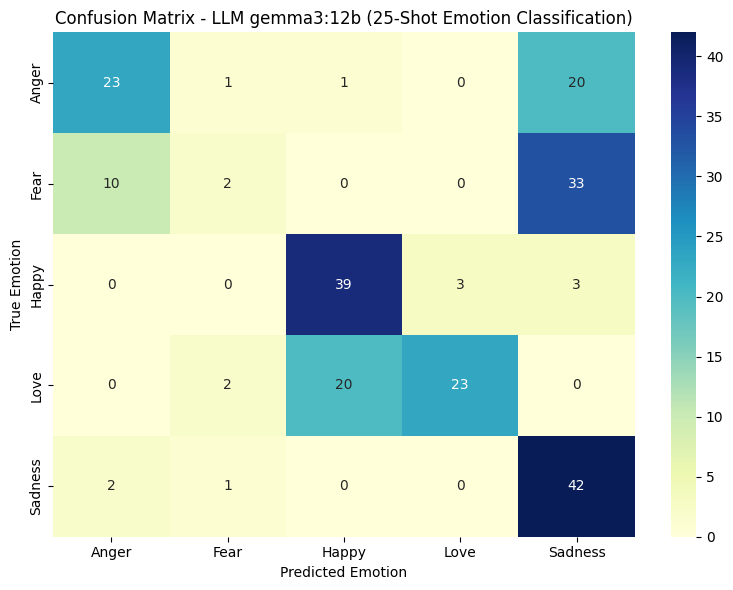

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Buat confusion matrix ===
cm = confusion_matrix(y_true, y_pred, labels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'])

# === Plot heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'],
            yticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'])

plt.title("Confusion Matrix - LLM gemma3:12b (25-Shot Emotion Classification)")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.tight_layout()
plt.savefig("confusion_matrix_emotion_llm.png", dpi=300)
print("✅ Confusion matrix disimpan di 'confusion_matrix_emotion_llm.png'")
plt.show()